# Setup and Dependencies
Import required libraries including TensorFlow, NumPy, and image processing utilities.

In [1]:
# Import required libraries including TensorFlow, NumPy, and image processing utilities
import tensorflow as tf # type: ignore
import numpy as np # type: ignore
from tensorflow.keras.preprocessing import image # type: ignore
from tensorflow.keras.models import load_model # type: ignore
import matplotlib.pyplot as plt # type: ignore

# Data Loading and Preprocessing
Load and preprocess the food image dataset, including resizing and normalization.

Found 993 files belonging to 9 classes.
Using 795 files for training.
Found 993 files belonging to 9 classes.
Using 198 files for validation.


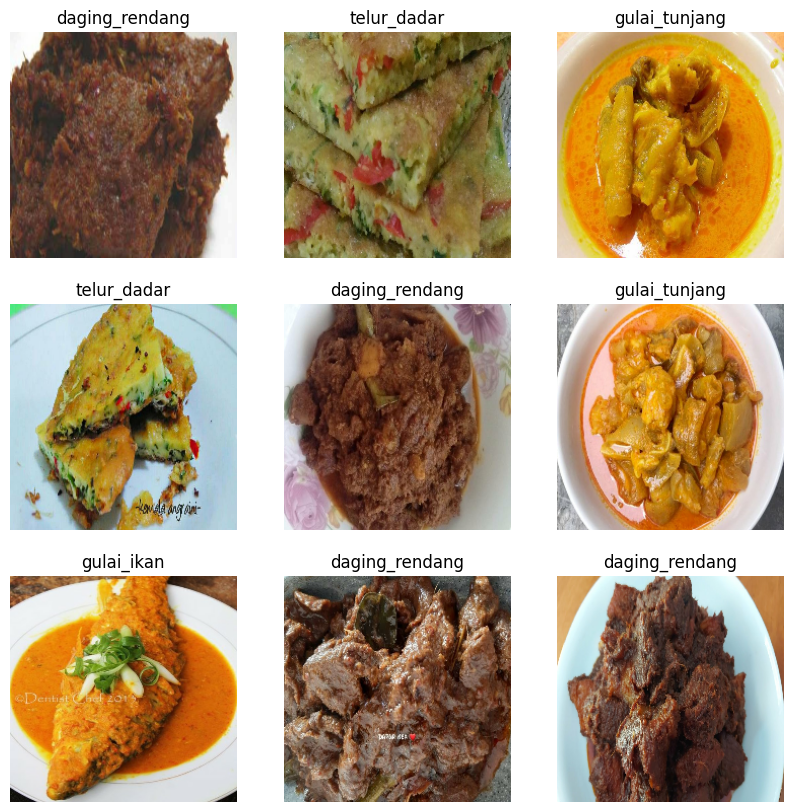


Available food classes:
0: ayam_goreng
1: ayam_pop
2: daging_rendang
3: dendeng_batokok
4: gulai_ikan
5: gulai_tambusu
6: gulai_tunjang
7: telur_balado
8: telur_dadar


In [2]:
# Load and preprocess the food image dataset, including resizing and normalization

# Define the path to the dataset
dataset_path = 'data\dataset_padang_food'

# Load the dataset using TensorFlow's image_dataset_from_directory
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32
)

class_names = train_dataset.class_names

# Normalize the pixel values to be between 0 and 1
normalization_layer = tf.keras.layers.Rescaling(1./255)

normalized_train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
normalized_validation_dataset = validation_dataset.map(lambda x, y: (normalization_layer(x), y))

# Display a few images from the training dataset
plt.figure(figsize=(10, 10))
for images, labels in normalized_train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(class_names[labels[i]])  # Use class_names instead of numerical labels
        plt.axis("off")
plt.show()

# Print all class names
print("\nAvailable food classes:")
for i, name in enumerate(class_names):
    print(f"{i}: {name}")

# Model Architecture Definition
Define the CNN architecture with proper input shapes and layer configurations.

In [3]:
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Create the model with proper input shape
model = models.Sequential([
    layers.Conv2D(16, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Conv2D(16, (3, 3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.Flatten(),
    layers.Dropout(0.5),  # Tingkatkan dropout
    layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),  # Regularisasi
    layers.Dropout(0.5),  # Dropout tambahan
    layers.Dense(9, activation='softmax')
])

# Display the model architecture
model.summary()

e:\App\Bahasa\Python\anaconda3\envs\TensorFlow\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 16)   │           448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 16)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 32)   │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 16)     │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10816)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     2,769,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         2,313 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,781,177 (10.61 MB)

 Trainable params: 2,781,177 (10.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training Configuration
Set up training parameters, optimizer, and loss function.

### Define Training Parameters
Set up essential training parameters like epochs, batch size, and learning rate.

In [4]:
# Set up training parameters, optimizer, and loss function

# Define training parameters
epochs = 20
batch_size = 32
learning_rate = 0.001

### Configure Model Compilation
Compile the model with appropriate optimizer, loss function, and metrics for training.

In [5]:
# Configure Model Compilation

# Compile the model with appropriate optimizer, loss function, and metrics for training
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

### Set Up Training Callbacks
Configure callbacks for model checkpointing and early stopping to optimize training.

In [6]:
# Set Up Training Callbacks

# Configure callbacks for model checkpointing and early stopping to optimize training
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='best_model.keras', 
        save_best_only=True, 
        monitor='val_loss', 
        mode='min'
    ),
    tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=5, 
        restore_best_weights=True
    ),
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
]

### Model Training
Train the model with proper batch size and validation setup.

In [7]:
# Train the model with the training dataset and validate with the validation dataset

history = model.fit(
    normalized_train_dataset,
    validation_data=normalized_validation_dataset,
    epochs=20,
    callbacks=callbacks
)

Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.1261 - loss: 5.7886 - val_accuracy: 0.1616 - val_loss: 3.2691 - learning_rate: 0.0010
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 125ms/step - accuracy: 0.1819 - loss: 3.0084 - val_accuracy: 0.3283 - val_loss: 2.4553 - learning_rate: 0.0010
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 122ms/step - accuracy: 0.3428 - loss: 2.3197 - val_accuracy: 0.4798 - val_loss: 1.8649 - learning_rate: 0.0010
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.4006 - loss: 1.9447 - val_accuracy: 0.3485 - val_loss: 1.9645 - learning_rate: 0.0010
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 116ms/step - accuracy: 0.4326 - loss: 1.8804 - val_accuracy: 0.5404 - val_loss: 1.6731 - learning_rate: 0.0010
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 119ms/step - accuracy: 0.5545 - loss: 1.7123 - val_accuracy: 0.5303 - val_loss: 1.7538 - learning_rate: 0.0010
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 118ms/step - accuracy: 0.6202 - loss: 1.5553 - 

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

train_data = datagen.flow_from_directory(
    'path_to_train_dir',
    target_size=(224, 224),
    batch_size=32,
    class_mode='sparse'
)


FileNotFoundError: [WinError 3] The system cannot find the path specified: 'path_to_train_dir'

### Monitor Training Progress
Visualize and analyze training metrics including accuracy and loss curves.

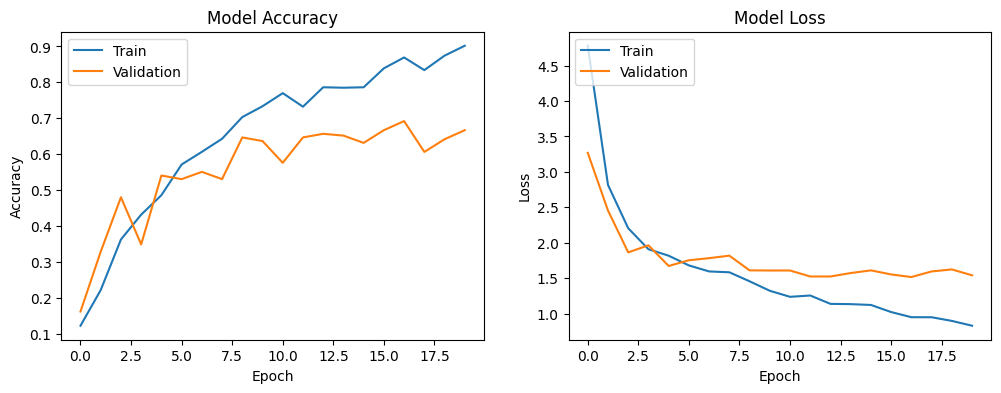

In [9]:
# Monitor Training Progress

import matplotlib.pyplot as plt # type: ignore

# Plot training & validation accuracy values
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.show()

# Image Preprocessing for Prediction
Implement proper image preprocessing pipeline for prediction input.

In [ ]:
# Load and preprocess a single image for prediction
def preprocess_image(image_path):
    # Load the image
    img = image.load_img(image_path, target_size=(224, 224))
    
    # Convert the image to an array
    img_array = image.img_to_array(img)
    
    # Expand dimensions to match the model input shape
    img_array = np.expand_dims(img_array, axis=0)
    
    # Normalize the image array
    img_array = img_array / 255.0
    
    return img_array

# Example usage
image_path = 'temp.jpg'
preprocessed_image = preprocess_image(image_path)

# Make a prediction using the model
predictions = model.predict(preprocessed_image)

# Get the predicted class
predicted_class = np.argmax(predictions[0])

# Get the predicted class name
predicted_class_name = class_names[predicted_class]

print('Predicted class:', predicted_class_name)

# Making Predictions
Create robust prediction function with proper error handling for shape mismatches.

In [ ]:
# Making Predictions

def make_prediction(model, image_path):
    try:
        # Preprocess the image
        img_array = preprocess_image(image_path)
        
        # Make a prediction using the model
        predictions = model.predict(img_array)
        
        # Get the predicted class
        predicted_class = np.argmax(predictions[0])
        
        return predicted_class
    except tf.errors.InvalidArgumentError as e:
        print(f"Error during prediction: {e}")
        return None

# Example usage
image_path = 'temp.jpg'
predicted_class = make_prediction(model, image_path)

if predicted_class is not None:
    predicted_class_name = class_names[predicted_class]
    print('Predicted class:', predicted_class_name)
else:
    print('Prediction failed due to an error.')

# Error Handling and Validation
Implement input validation and error handling for prediction pipeline.

In [ ]:
# Error Handling and Validation

def validate_image(image_path):
    try:
        # Check if the image path is valid
        img = image.load_img(image_path)
        return True
    except Exception as e:
        print(f"Invalid image path or file: {e}")
        return False

def preprocess_image(image_path):
    if not validate_image(image_path):
        return None
    
    try:
        # Load the image
        img = image.load_img(image_path, target_size=(224, 224))
        
        # Convert the image to an array
        img_array = image.img_to_array(img)
        
        # Expand dimensions to match the model input shape
        img_array = np.expand_dims(img_array, axis=0)
        
        # Normalize the image array
        img_array = img_array / 255.0
        
        return img_array
    except Exception as e:
        print(f"Error during image preprocessing: {e}")
        return None

def make_prediction(model, image_path):
    try:
        # Preprocess the image
        img_array = preprocess_image(image_path)
        
        if img_array is None:
            return None
        
        # Make a prediction using the model
        predictions = model.predict(img_array)
        
        # Get the predicted class
        predicted_class = np.argmax(predictions[0])
        
        return predicted_class
    except tf.errors.InvalidArgumentError as e:
        print(f"Error during prediction: {e}")
        return None
    except Exception as e:
        print(f"Unexpected error during prediction: {e}")
        return None

# Example usage
image_path = 'temp.jpg'
predicted_class = make_prediction(model, image_path)

if predicted_class is not None:
    predicted_class_name = class_names[predicted_class]
    print('Predicted class:', predicted_class_name)
else:
    print('Prediction failed due to an error.')